I'll put here a usefull command to start mlflow using an sqlite local database on the data folder.  

`mlflow ui --backend-store-uri sqlite:///data/mlflow.db`

In [1]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import feature_extraction
from sklearn import linear_model
from sklearn import metrics
# mlflow
import mlflow

mlflow.set_tracking_uri("sqlite:///data/mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='./mlruns/1', experiment_id='1', lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [2]:
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [3]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = feature_extraction.DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

metrics.mean_squared_error(y_train, y_pred, squared=False)

9.827368941909368

/home/luba/.local/share/virtualenvs/mlops-zoomcamp-4Pi15hoo/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/luba/.local/share/virtualenvs/mlops-zoomcamp-4Pi15hoo/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


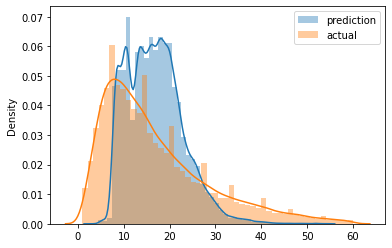

In [4]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [5]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [6]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [7]:
len(df_train), len(df_val)

(73908, 61921)

In [8]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [9]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = feature_extraction.DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [10]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [11]:
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

metrics.mean_squared_error(y_val, y_pred, squared=False)

7.758715208537182

In [12]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [17]:
with mlflow.start_run():

    mlflow.set_tag("developer", "luba")
    # very simple data versioning way

    alpha = 0.01

    lr = linear_model.Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = metrics.mean_squared_error(y_val, y_pred, squared=False)

    # params to log
    params_to_log = {
        "train_data_path": "./data/green_tripdata_2021-01.parquet",
        "valid_data_path": "./data/green_tripdata_2021-02.parquet",
        "alpha": alpha,
    }    

    mlflow.log_metric("rmse", rmse)
    mlflow.log_params(params_to_log)

- I got an error, because I tried to log the same param more than one time on one specific experiment.
- There is an workaround to save the name of the jupyter notebook, get latter

## Using Hyperparam tuning with mlflow

In [18]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [19]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)


In [25]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = metrics.mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)
    
    return {"loss": rmse, 'status': STATUS_OK}

In [28]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 30, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42,
    "tree_method": "gpu_hist"
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

[05:58:41] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:12.53966                          
[1]	validation-rmse:8.88482                           
[2]	validation-rmse:7.50717                           
[3]	validation-rmse:7.00611                           
[4]	validation-rmse:6.80670                           
[5]	validation-rmse:6.72353                           
[6]	validation-rmse:6.68531                           
[7]	validation-rmse:6.66889                           
[8]	validation-rmse:6.65606                           
[9]	validation-rmse:6.64816                           
[10]	validation-rmse:6.64408                          
[11]	validation-rmse:6.63908                          
[12]	validation-rmse:6.63311                          
[13]	validation-rmse:6.62811                          
[14]	validation-rmse:6.62362                          
[15]	validation-rmse:6.61971                          
[

: 

: 